In [1]:
%cd ..

/home/ubuntu/dev/reid/pepper


In [2]:
# builtin
from collections import Counter, defaultdict
from copy import deepcopy
import os.path as osp
import re
from shutil import copy2 as copy

# third-party
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import torch

# mm
import mmcv
from mmcv import Config
from mmcv.utils import build_from_cfg

In [3]:
from pepper.datasets import DATASETS

In [4]:
cfg = Config.fromfile("tests/configs/mini_mars.py")
print(cfg.pretty_text)

img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
num_frames = 16
train_pipeline = [
    dict(type='VideoSampler', method='random_crop', seq_len=16),
    dict(type='LoadMultiImagesFromFile', to_float32=True),
    dict(type='SeqResize', size=(256, 128), interpolation='bilinear'),
    dict(type='SeqRandomFlip', flip_prob=0.5, direction='horizontal'),
    dict(
        type='SeqNormalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='VideoCollect', keys=['img', 'gt_label']),
    dict(type='FormatBundle')
]
test_pipeline = [
    dict(type='LoadMultiImageFromFile'),
    dict(type='SeqResize', size=(256, 128), interpolation='bilinear'),
    dict(
        type='SeqNormalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='VideoCollect', keys=['img'], meta_keys=[])
]
data_type = 'VideoDataset'
data_root = 'tests

In [5]:
dataset = build_from_cfg(cfg.data.train, DATASETS)

In [6]:
print(dataset.ann_file)
# print(dataset.data_infos)
print(len(dataset.data_infos))
print(len(dataset))

tests/data/mini_mars/gtPepper/train.json
32
32


In [14]:
sample = dataset[0]

In [15]:
print(sample.keys())
print(type(sample['img'].data), type(sample['gt_label'].data), type(sample['img_metas']))
print(sample['img_metas'][0].data)
print(sample['img_metas'][-1].data)
print(sample['img'].data.shape)

dict_keys(['img', 'gt_label', 'img_metas'])
<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'list'>
{'filename': 'tests/data/mini_mars/bbox_train/0003/0003C4T0003F073.jpg', 'ori_filename': 'bbox_train/0003/0003C4T0003F073.jpg', 'ori_shape': (256, 128, 3), 'img_shape': (256, 128, 3), 'pad_shape': (256, 128, 3), 'scale_factor': 1.0, 'flip': True, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}, 'frame_id': 72, 'is_video_data': True}
{'filename': 'tests/data/mini_mars/bbox_train/0003/0003C4T0003F088.jpg', 'ori_filename': 'bbox_train/0003/0003C4T0003F088.jpg', 'ori_shape': (256, 128, 3), 'img_shape': (256, 128, 3), 'pad_shape': (256, 128, 3), 'scale_factor': 1.0, 'flip': True, 'flip_direction': 'horizontal', 'img_norm_cfg': {'mean': array([123.675, 116.28 , 103.53 ], dtype=float32), 'std': array([58.395, 57.12 , 57.375], dtype=float32), 'to_rgb': True}, 'f

In [16]:
class UnNormalize(object):
    def __init__(self, mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375]):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)  # WARN: this is inplace!!!
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [17]:
mean = [123.675, 116.28, 103.53]
std = [58.395, 57.12, 57.375]

unnorm = UnNormalize(mean=mean, std=std)

In [18]:
def concat_tracklet(imgs, max_len=16):
    num_imgs, c, h, w = imgs.shape
    
    if num_imgs < max_len:
        max_len = num_imgs
        
    out = torch.zeros((c, h, w * max_len))
    for i in range(max_len):
        out[:, :, w * i : w * (i + 1)] = imgs[i]
        
    return out

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


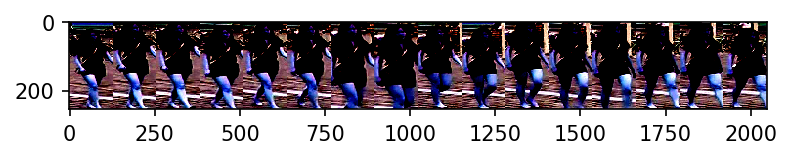

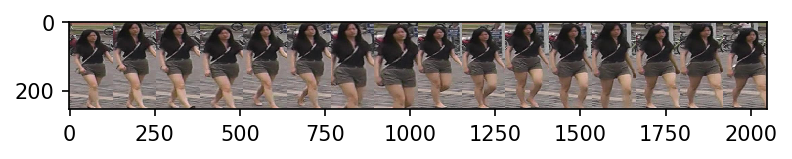

In [19]:
imgs = sample['img'].data

img = concat_tracklet(imgs)

unnorm_img = unnorm(deepcopy(img))
img = img.numpy().transpose((1, 2, 0))[:, :, [2, 1, 0]]
unnorm_img = unnorm_img.numpy().transpose((1, 2, 0)).astype(np.uint8)

plt.imshow(img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

plt.imshow(unnorm_img, interpolation='nearest')
plt.gcf().set_dpi(150)
plt.show()

In [53]:
print(sample['gt_label'])
print(len(sample['gt_label']))

DataContainer(tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]))
65
